In [95]:
use_saved_model = True
saved_model_name = "my_model"
percent_training_data = 0.1  # 1 = 100% of data, 0.5 = 50% of data, etc.

In [96]:

# Install kaggle and dataset, extract data
"""%matplotlib inline
%pip install kaggle
%pip install pydot
%pip install kaggle
%pip install tensorflow-metal
!brew install graphviz
!/Users/jon/Library/Python/3.9/bin/kaggle competitions download -c sf-crime
import shutil
shutil.unpack_archive("sf-crime.zip", "sf-crime")
shutil.unpack_archive("sf-crime/train.csv.zip", "sf-crime/train")
shutil.unpack_archive("sf-crime/test.csv.zip", "sf-crime/test")
shutil.unpack_archive("sf-crime/sampleSubmission.csv.zip", "sf-crime/sampleSubmission")
"""

'%matplotlib inline\n%pip install kaggle\n%pip install pydot\n%pip install kaggle\n%pip install tensorflow-metal\n!brew install graphviz\n!/Users/jon/Library/Python/3.9/bin/kaggle competitions download -c sf-crime\nimport shutil\nshutil.unpack_archive("sf-crime.zip", "sf-crime")\nshutil.unpack_archive("sf-crime/train.csv.zip", "sf-crime/train")\nshutil.unpack_archive("sf-crime/test.csv.zip", "sf-crime/test")\nshutil.unpack_archive("sf-crime/sampleSubmission.csv.zip", "sf-crime/sampleSubmission")\n'

In [97]:

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential, Model
from keras.layers import UpSampling2D, Add, Input, BatchNormalization, Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split

import re
import random

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [98]:
# load csv data from train.csv
train = pd.read_csv("sf-crime/train/train.csv")
train.sample(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
531646,2007-11-12 18:31:00,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Monday,INGLESIDE,"ARREST, CITED",GENEVA AV / LISBON ST,-122.438623,37.715309
116562,2013-10-19 00:01:00,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Saturday,PARK,NONE,300 Block of LAGUNAHONDA BL,-122.458680,37.748155
582866,2007-02-10 11:18:00,ASSAULT,BATTERY,Saturday,NORTHERN,NONE,700 Block of EDDY ST,-122.420026,37.783050
544281,2007-09-07 04:00:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Friday,TARAVAL,"ARREST, BOOKED",19TH AV / EUCALYPTUS DR,-122.474855,37.731065
365822,2010-04-09 23:10:00,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Friday,NORTHERN,NONE,OLIVE ST / LARKIN ST,-122.417809,37.784710


In [99]:
# load csv data from test.csv
test_useless = pd.read_csv("sf-crime/test/test.csv")
test_useless.sample(5)
test_useless["Address"].sample(10)

416108               1700 Block of LOMBARD ST
664107                   4TH ST / HARRISON ST
337839                 800 Block of BRYANT ST
697548                NEWHALL ST / OAKDALE AV
832450                600 Block of STANYAN ST
342313                 0 Block of HARRISON ST
371964                 2700 Block of GREEN ST
225281    THE EMBARCADEROSOUTH ST / BRYANT ST
98688                 300 Block of WEBSTER ST
471907              400 Block of BAY SHORE BL
Name: Address, dtype: object

In [100]:
# convert the category column to a one hot encoded array
y_train = pd.get_dummies(train["Category"])
class_names = y_train.columns
x_train = train.drop(["Category", "Descript", "Resolution"], axis=1)
x_train

,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [101]:
def string_to_int(string):
    return sum([ord(c) for c in string])

# a function that takes an array of unique values and returns a dictionary with values as keys and indices as values
def get_dict(array):
    return {array[i]: i+1 for i in range(len(array))}

def min_max_normalize(array, min=None, max=None):
    if min is None: min = array.min()
    if max is None: max = array.max()
    return (array - min) / (max - min)

def address_get_dummies(data: pd.DataFrame, prefix=None):
    # create a new dataframe
    df = pd.DataFrame()

    # get all the street types
    types = []
    for address in data:
        # get all two chars that are capitalized with regex
        types += [prefix + "_" + match for match in re.findall(r"\b[A-Z]{2}\b", address)]
    types = list(set(types))

    # create a column for each street type
    # and set it to 1 if the address contains that street type
    for street_type in types:
        df[street_type] = data.apply(lambda x: 1.0 if street_type in x else 0.0)

    return df

def preprocess_data(df):
    """
    Preprocesses the data by converting strings to integers without normalization
    """
    # convert date to datetime
    df["Dates"] = pd.to_datetime(df["Dates"], format="%Y-%m-%d %H:%M:%S")
    # add new columns
    df["Year"] = df["Dates"].dt.year
    df["Month"] = df["Dates"].dt.month
    df["Day"] = df["Dates"].dt.day
    df["Hour"] = df["Dates"].dt.hour
    df["Minute"] = df["Dates"].dt.minute
    df["DayOfWeek"] = df["Dates"].dt.dayofweek
    df["WeekOfYear"] = df["Dates"].dt.isocalendar().week
    df = df.drop(["Dates"], axis=1)
    # convert pd district to one-hot encoding
    df = pd.concat([df, pd.get_dummies(df["PdDistrict"], prefix="PdDistrict", dtype=np.float32)], axis=1)
    df = df.drop(["PdDistrict"], axis=1)
    # convert addresses to one-hot encoding
    df = pd.concat([df, address_get_dummies(df["Address"], prefix="Address")], axis=1)
    df = df.drop(["Address"], axis=1)

    return df

def normalize_data(df):
    """
    Normalizes the data
    """
    df = df.copy()

    df["DayOfWeek"] = min_max_normalize(df["DayOfWeek"])
    df["Year"] = min_max_normalize(df["Year"])
    df["Month"] = min_max_normalize(df["Month"])
    df["Day"] = min_max_normalize(df["Day"])
    df["Hour"] = min_max_normalize(df["Hour"], 0, 23)
    df["Minute"] = min_max_normalize(df["Minute"], min=0, max=59)
    df["WeekOfYear"] = min_max_normalize(df["WeekOfYear"])
    
    # map the coordinates to a number by using min max normalization
    df["X"] = min_max_normalize(train["X"], -180, 180)
    df["Y"] = min_max_normalize(train["Y"], -90, 90)

    return df

def convert_df_to_numpy(df):
    """
    Converts the pandas dataframe to a numpy array
    """
    return np.asarray(df).astype(np.float32)

def split_data(x, y, test_size=0.2, np=False):
    """
    Splits the data into a training and validation set
    """
    # split the data into a training and validation set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=42)
    # convert the dataframes to numpy arrays
    if np:
        x_train = convert_df_to_numpy(x_train)
        x_val = convert_df_to_numpy(x_val)
        y_train = convert_df_to_numpy(y_train)
        y_val = convert_df_to_numpy(y_val)
    return x_train, x_val, y_train, y_val

x_train: pd.DataFrame= preprocess_data(x_train)
x_train: pd.DataFrame = normalize_data(x_train)

# take only x % of the training data with random sampling
x_train = x_train.sample(int(len(x_train) * percent_training_data))
y_train = y_train.loc[x_train.index]


# split the data into time and location data
# easier to get time of data and drop columns
x_train_time: pd.DataFrame = x_train[['DayOfWeek', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'WeekOfYear']]
# x_train_location is the rest of the data
x_train_location: pd.DataFrame = x_train.drop(columns=['DayOfWeek', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'WeekOfYear'], axis=1)

# put the time and location data back together
x_train_: pd.DataFrame = pd.concat([x_train_time, x_train_location], axis=1)

x_train, x_val, y_train, y_val = split_data(x_train_, y_train, np=True)

x_train_.sample(20)


,DayOfWeek,Year,Month,Day,Hour,Minute,WeekOfYear,X,Y,PdDistrict_BAYVIEW,...,Address_SF,Address_EX,Address_MT,Address_ST,Address_AL,Address_WY,Address_FE,Address_MC,Address_BL,Address_US
186723,0.666667,0.750000,0.909091,0.500000,0.956522,0.000000,0.88,0.159725,0.709756,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
678529,0.000000,0.166667,0.818182,0.066667,0.826087,0.000000,0.76,0.159872,0.709597,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
725414,1.000000,0.166667,0.000000,0.966667,0.000000,0.254237,0.04,0.159974,0.710002,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786787,1.000000,0.083333,0.181818,0.666667,0.521739,0.762712,0.2,0.159933,0.709596,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345677,0.500000,0.583333,0.545455,0.933333,0.913043,0.440678,0.56,0.159939,0.710028,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295482,0.833333,0.666667,0.272727,0.733333,0.434783,0.508475,0.28,0.159989,0.709874,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126556,0.666667,0.833333,0.727273,0.166667,0.304348,0.084746,0.68,0.159918,0.709784,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301116,0.666667,0.666667,0.181818,0.800000,0.391304,0.000000,0.2,0.159979,0.709888,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
513867,0.000000,0.416667,0.090909,0.566667,0.869565,0.084746,0.12,0.159977,0.709977,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873128,0.666667,0.000000,0.000000,0.766667,0.826087,0.000000,0.04,0.160012,0.709789,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
def plot_learning_curves(history):
    n = len(history.history['loss'])
    plt.plot(np.arange(1, n+1), history.history['loss'], label="training loss")
    plt.plot(np.arange(1, n+1), history.history['val_loss'], label="validation loss")
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(1, n+1, 2))


def DenseReluBatchNorm(units: int, activation: str = "relu", use_bias: bool = True):
    return keras.Sequential(
        [
            Dense(units, use_bias=use_bias),
            Activation(activation),
            BatchNormalization(),
        ]
    )

def residual_block(x, units, activation='relu', kernel_initializer='he_normal', start_col=0, end_col=0):
    x_shortcut_time = x
    x_shortcut = x[:12] # Store the initial value of X in a variable
    # Perform convolution + batch norm operations on X
    x = Dense(units=units, kernel_initializer=kernel_initializer)(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.2)(x)
    x = Dense(units=x_shortcut.shape[1], kernel_initializer=kernel_initializer)(x)
    assert x.shape == x_shortcut.shape  # needs to be the same shape to add
    x = Add()([x, x_shortcut]) # SKIP Connection
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def build_model():
    input_shape = x_train.shape[1]
    output_shape = y_train.shape[1]

    input_tensor = Input(shape=(input_shape,), name='input')

    x = residual_block(x=input_tensor, units=128, start_col=0, end_col=12)
    x = residual_block(x=x, units=64)
    x = residual_block(x=x, units=32)

    output_tensor = Dense(units=y_train.shape[1], activation='softmax')(x)  # we need to classify the category of the crime
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_model()

tf.keras.utils.plot_model(model, to_file="/tmp/model.png", show_layer_activations=True, show_shapes=True, show_dtype=True, show_layer_names=True)


SyntaxError: invalid syntax (3720760449.py, line 33)

In [199]:
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 49)]         0           []                               
                                                                                                  
 dense_109 (Dense)              (None, 128)          6400        ['input[0][0]']                  
                                                                                                  
 activation_91 (Activation)     (None, 128)          0           ['dense_109[0][0]']              
                                                                                                  
 batch_normalization_70 (BatchN  (None, 128)         512         ['activation_91[0][0]']          
 ormalization)                                                                             

In [200]:
# against Vanishing/Exploding Gradients
optimizer = Adam(learning_rate=0.005, clipnorm=1.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=7,
)

if use_saved_model:
    model = tf.keras.models.load_model(f'./{saved_model_name}')

history = model.fit(
  x_train,
  y_train,
  epochs=30,
  batch_size=32,
  validation_split=.1,
  callbacks=[early_stopping],
  verbose=1,
)

Epoch 1/30


2022-12-12 16:16:37.981244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1976/1976 [==============================] - ETA: 0s - loss: 2.7352 - accuracy: 0.1848

2022-12-12 16:17:56.344752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1976/1976 [==============================] - 83s 41ms/step - loss: 2.7352 - accuracy: 0.1848 - val_loss: 2.7337 - val_accuracy: 0.1977
Epoch 2/30
1976/1976 [==============================] - 77s 39ms/step - loss: 2.7346 - accuracy: 0.1893 - val_loss: 2.7097 - val_accuracy: 0.1977
Epoch 3/30
1976/1976 [==============================] - 78s 39ms/step - loss: 2.7395 - accuracy: 0.1859 - val_loss: 2.7622 - val_accuracy: 0.1977
Epoch 4/30
1976/1976 [==============================] - 77s 39ms/step - loss: 2.7350 - accuracy: 0.1854 - val_loss: 3.3246 - val_accuracy: 0.1977


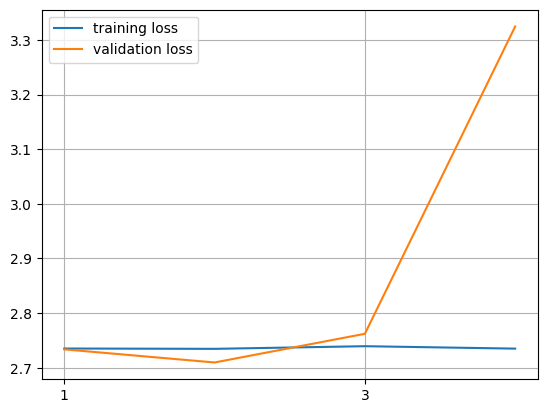

In [201]:
plot_learning_curves(history)

In [202]:
from sklearn.metrics import classification_report

predicted_class_probabilities = model.predict(x_val)
predicted_labels = np.argmax(predicted_class_probabilities, axis=1)

# convert predicated_labels to one-hot encoding
predicted_labels = keras.utils.to_categorical(predicted_labels, num_classes=predicted_class_probabilities.shape[1])

print(classification_report(y_true=y_val, y_pred=predicted_labels, target_names=class_names))


2022-12-12 16:22:48.739848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5488/5488 [==============================] - 31s 5ms/step
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       321
                    ASSAULT       0.00      0.00      0.00     15364
                 BAD CHECKS       0.00      0.00      0.00        72
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7389
         DISORDERLY CONDUCT       0.00      0.00      0.00       828
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       459
              DRUG/NARCOTIC       0.00      0.00      0.00     10723
                DRUNKENNESS       0.00      0.00      0.00       857
               EMBEZZLEMENT       0.00      0.00      0.00       222
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        92
     FORGERY/COUNTERFEITING       0.00      

/Users/jon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


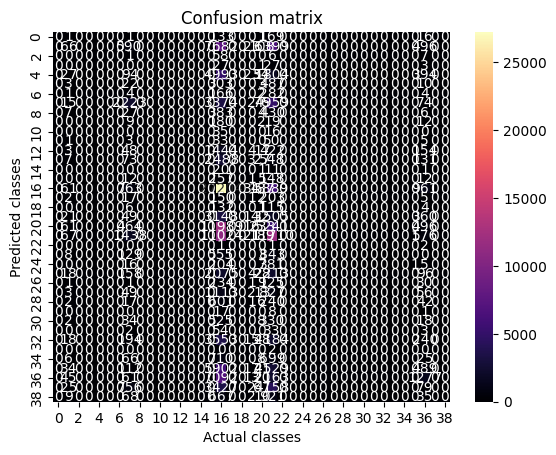

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_val.argmax(axis=1), predicted_labels.argmax(axis=1)), annot=True, fmt='d', cmap='magma').set(
    xlabel="Actual classes", ylabel="Predicted classes", title='Confusion matrix')
plt.show()


In [203]:
model.save(saved_model_name, save_format='tf')

INFO:tensorflow:Assets written to: my_model/assets
